In [ ]:
#Mount Google Drive
#to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import neccessary libraries
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import PIL
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from PIL import Image
from PIL.ImageDraw import Draw

                                            filename  width  height   class  \
0  d66fe3c0f7d5a396_jpg.rf.0d947e33ef400474603dc7...    416     416    Crab   
1  b8d029497cf7bac6_jpg.rf.0180374b736435cd50e82b...    416     416  Shrimp   
2  b8d029497cf7bac6_jpg.rf.0180374b736435cd50e82b...    416     416  Shrimp   
3  faa591da3ab1fa90_jpg.rf.0b5cc08196694e1f25b4b0...    416     416  Shrimp   
4  faa591da3ab1fa90_jpg.rf.0b5cc08196694e1f25b4b0...    416     416  Shrimp   

   xmin  ymin  xmax  ymax  
0   148   115   384   302  
1   101     3   164   134  
2   246   112   366   323  
3     0   276   167   415  
4     6    27   138   143  
filename    d66fe3c0f7d5a396_jpg.rf.0d947e33ef400474603dc7...
width                                                     416
height                                                    416
class                                                    Crab
xmin                                                      148
ymin                                           

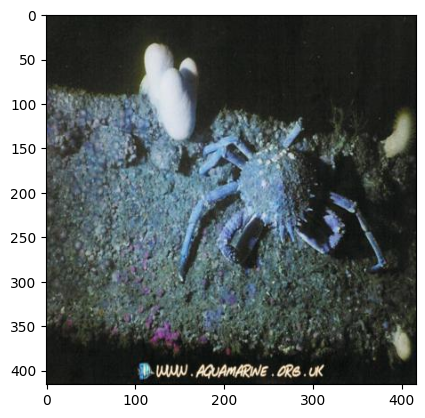

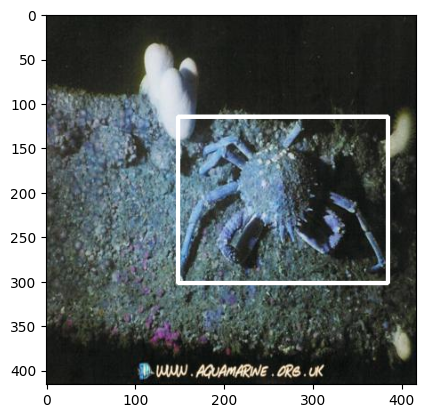

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/train/_annotations.csv')
print(df.head())

print(df.iloc[0]) #print the first row of data
np_array = df.values
print(np_array)
print(len(np_array[0]))

# get a test first image
img_ = cv2.imread('/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/train/d66fe3c0f7d5a396_jpg.rf.0d947e33ef400474603dc78f438e2101.jpg')

#show the box and image as a sanity check
plt.imshow(img_)

# draw a bounding box around the animal
print(df.loc[0, ['xmin', 'xmax', 'ymin', 'ymax']])
xmin = int(df.loc[0, 'xmin'])
xmax = int(df.loc[0, 'xmax'])
ymin = int(df.loc[0, 'ymin'])
ymax = int(df.loc[0, 'ymax'])
cv2.rectangle(img_,(xmin,ymin),(xmax,ymax),(255,255,255), 3)

#show the box and image as a sanity check
plt.figure()
plt.imshow(img_)


In [ ]:
#Function to process all the images
#They are annotated in the csv file, but need to be loaded appropriately into a df
def load_and_process_data(csv_file, image_dir):

    #read the annotations file
    image_records = pd.read_csv(csv_file)
    image_path = os.path.join(os.getcwd(), image_dir)

    images = []
    targets = []
    labels = []

    for index, row in image_records.iterrows():
        (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

        #load the image
        image_fullpath = os.path.join(image_path, filename)
        img = keras.preprocessing.image.load_img(image_fullpath)
        img_arr = keras.preprocessing.image.img_to_array(img)

        #normalize the image based on the width and height
        xmin = round(xmin/ width, 2)
        ymin = round(ymin/ height, 2)
        xmax = round(xmax/ width, 2)
        ymax = round(ymax/ height, 2)

        #add it to the data frame
        images.append(img_arr)
        targets.append((xmin, ymin, xmax, ymax))
        labels.append(classes.index(class_name))
    return images, targets, labels

In [ ]:
#specific parameters to use with our dataset
#and load_and_process_data function
width = 416
height = 416
num_classes = 3
classes = ["Crab", "Shrimp", "Lobster"]

In [ ]:
# load and preprocess datasets
TRAINING_CSV_FILE = '/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/train/_annotations.csv'
VALIDATION_CSV_FILE = '/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/valid/_annotations.csv'
TESTING_CSV_FILE = '/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/test/_annotations.csv'

TRAINING_IMAGE_DIR = '/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/train'
VALIDATION_IMAGE_DIR = '/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/valid'
TESTING_IMAGE_DIR = '/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/test'

train_images, train_targets, train_labels = load_and_process_data(TRAINING_CSV_FILE, TRAINING_IMAGE_DIR)
validation_images, validation_targets, validation_labels = load_and_process_data(VALIDATION_CSV_FILE, VALIDATION_IMAGE_DIR)
test_images, test_targets, test_labels = load_and_process_data(TESTING_CSV_FILE, TESTING_IMAGE_DIR)

In [ ]:
# convert data to np.array; also one-hot encode class labels
train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)
train_labels = to_categorical(train_labels)

test_images = np.array(test_images)
test_targets = np.array(test_targets)
test_labels = np.array(test_labels)
test_labels = to_categorical(test_labels)

validation_images = np.array(validation_images)
validation_targets = np.array(validation_targets)
validation_labels = np.array(validation_labels)
validation_labels = to_categorical(validation_labels)
print(validation_labels[0], type(validation_labels))


[0. 0. 1.] <class 'numpy.ndarray'>


In [ ]:
# Try building model a different way

# Notes:
# using sparce_cat_cross without one-hot encoding went much faster (with rescalinf of input data (imgs))
# using cat_cross with one-hot encoding was slow

input_shape = (height, width, 3)

model = Sequential()

# Convolutional Phase
# Figure out a better way to use connvolutional layers
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape, name='bl_1')) # this made training go MUCH faster
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(48, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

# for classification output
classification_output = Dense(num_classes, activation='softmax', name='classification_output')(model.layers[-1].output)

# for localization output
bounding_box_output = Dense(4, activation='linear', name='bounding_box_output')(model.layers[-1].output)

model = Model(inputs=model.input, outputs=[classification_output, bounding_box_output])

losses = {
    "classification_output": "categorical_crossentropy",
    "bounding_box_output": "mse"
}

model.compile(loss=losses, optimizer='adam', metrics=['accuracy'], run_eagerly=True)

model.summary()

print(train_images.shape)
print(train_labels.shape)
print(train_targets.shape)
print(test_images.shape)
print(test_labels.shape)
print(test_targets.shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bl_1_input (InputLayer)     [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 bl_1 (Rescaling)            (None, 416, 416, 3)          0         ['bl_1_input[0][0]']          
                                                                                                  
 conv2d (Conv2D)             (None, 414, 414, 16)         448       ['bl_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 207, 207, 16)         0         ['conv2d[0][0]']              
 D)                                                                                           

In [ ]:
#Fit the model
history = model.fit(
    train_images,
    {"classification_output": train_labels, "bounding_box_output": train_targets},
    validation_data=(test_images, {"classification_output": test_labels, "bounding_box_output": test_targets}),
    epochs=20,
    batch_size=4
)

Epoch 1/20


215/215 [==============================] - 27s 76ms/step - loss: 12.1744 - classification_output_loss: 1.9428 - bounding_box_output_loss: 10.2316 - classification_output_accuracy: 0.6084 - bounding_box_output_accuracy: 0.4021 - val_loss: 1.0862 - val_classification_output_loss: 0.9595 - val_bounding_box_output_loss: 0.1267 - val_classification_output_accuracy: 0.5862 - val_bounding_box_output_accuracy: 0.4483
Epoch 2/20
215/215 [==============================] - 15s 69ms/step - loss: 0.7374 - classification_output_loss: 0.5207 - bounding_box_output_loss: 0.2168 - classification_output_accuracy: 0.8392 - bounding_box_output_accuracy: 0.4149 - val_loss: 1.0561 - val_classification_output_loss: 0.9466 - val_bounding_box_output_loss: 0.1095 - val_classification_output_accuracy: 0.6034 - val_bounding_box_output_accuracy: 0.3793
Epoch 3/20
215/215 [==============================] - 15s 72ms/step - loss: 0.4739 - classification_output_loss: 0.2882 - bounding_box_output_loss: 0.1858 - classifi

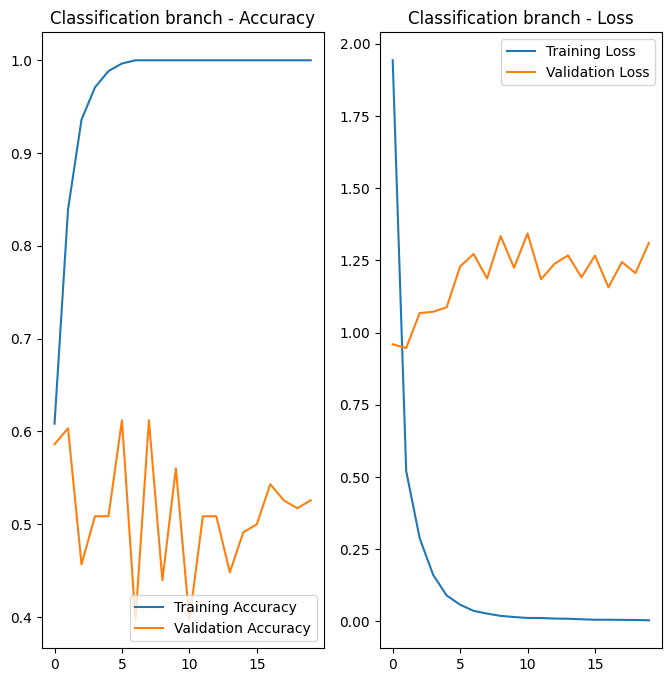

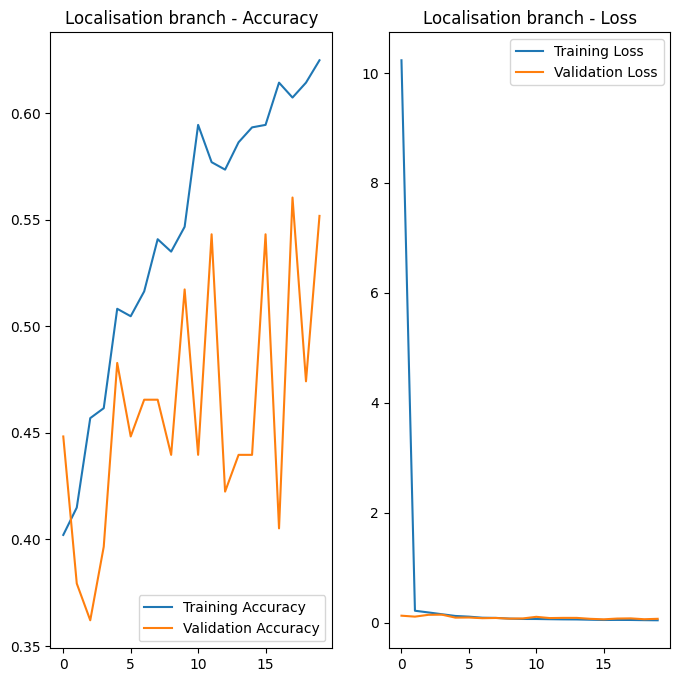

In [ ]:
#classification accuracy metrics
cl_accuracy = history.history['classification_output_accuracy']
cl_val_acc = history.history['val_classification_output_accuracy']

#bounding box accuracy metrics
bb_accuracy = history.history['bounding_box_output_accuracy']
bb_val_acc = history.history['val_bounding_box_output_accuracy']

#classification loss metrics
cl_loss = history.history['classification_output_loss']
cl_val_loss = history.history['val_classification_output_loss']

#bounding box loss metrics
bb_loss = history.history['bounding_box_output_loss']
bb_val_loss = history.history['val_bounding_box_output_loss']


#number of epochs
epochs_range = range(20)


#Plot the classification branch validation and training accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cl_accuracy, label='Training Accuracy')
plt.plot(epochs_range, cl_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Classification branch - Accuracy')

#Plot the classification branch validation and training loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, cl_loss, label='Training Loss')
plt.plot(epochs_range, cl_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Classification branch - Loss')
plt.show()

#Plot the localization branch validation and training accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bb_accuracy, label='Training Accuracy')
plt.plot(epochs_range, bb_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Localisation branch - Accuracy')

#Plot the localization branch validation and training loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, bb_loss, label='Training Loss')
plt.plot(epochs_range, bb_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Localisation branch - Loss')
plt.show()

1/1 [==============================] - 0s 107ms/step
['Crab', 'Shrimp', 'Lobster']
2
Lobster
1/1 [==============================] - 0s 23ms/step
['Crab', 'Shrimp', 'Lobster']
0
Crab
1/1 [==============================] - 0s 27ms/step
['Crab', 'Shrimp', 'Lobster']
0
Crab
1/1 [==============================] - 0s 25ms/step
['Crab', 'Shrimp', 'Lobster']
0
Crab
1/1 [==============================] - 0s 32ms/step
['Crab', 'Shrimp', 'Lobster']
1
Shrimp
1/1 [==============================] - 0s 29ms/step
['Crab', 'Shrimp', 'Lobster']
2
Lobster
1/1 [==============================] - 0s 28ms/step
['Crab', 'Shrimp', 'Lobster']
2
Lobster
1/1 [==============================] - 0s 26ms/step
['Crab', 'Shrimp', 'Lobster']
1
Shrimp
1/1 [==============================] - 0s 28ms/step
['Crab', 'Shrimp', 'Lobster']
2
Lobster
1/1 [==============================] - 0s 24ms/step
['Crab', 'Shrimp', 'Lobster']
0
Crab
1/1 [==============================] - 0s 27ms/step
['Crab', 'Shrimp', 'Lobster']
0
Crab
1/1 

<Figure size 2000x2000 with 0 Axes>

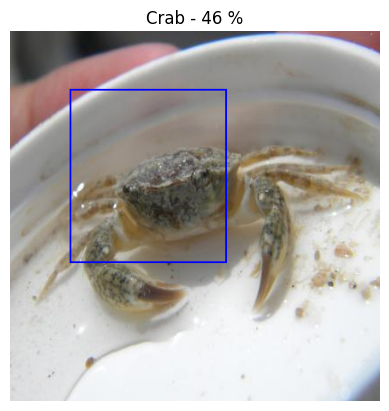

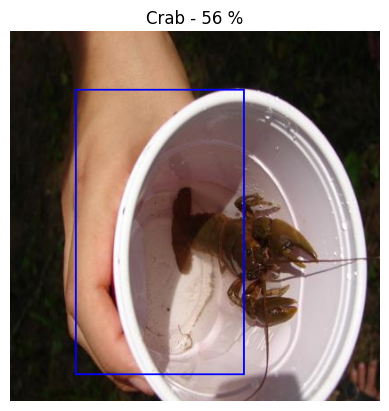

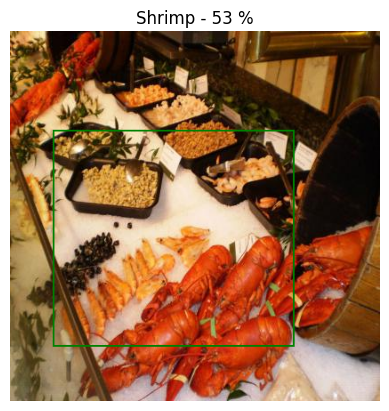

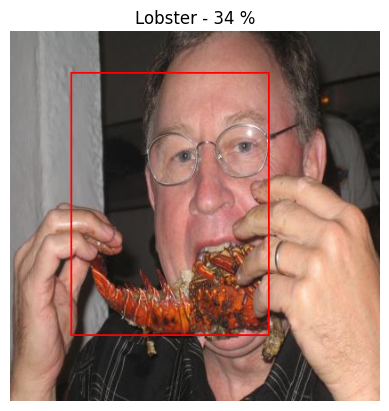

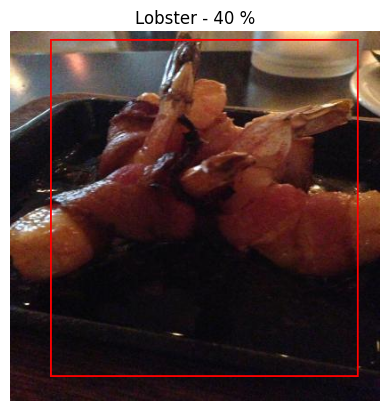

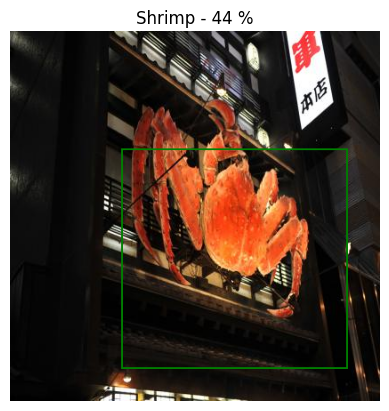

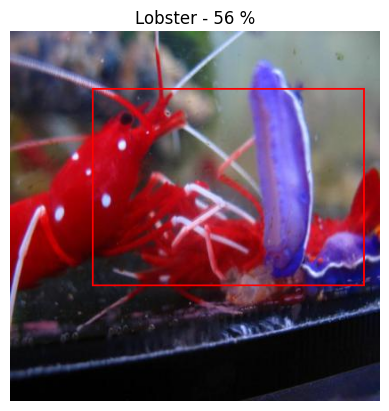

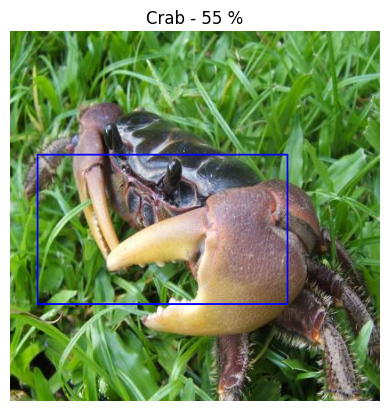

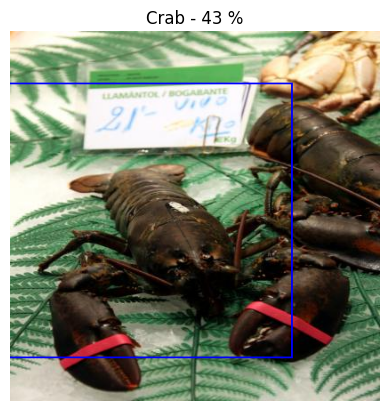

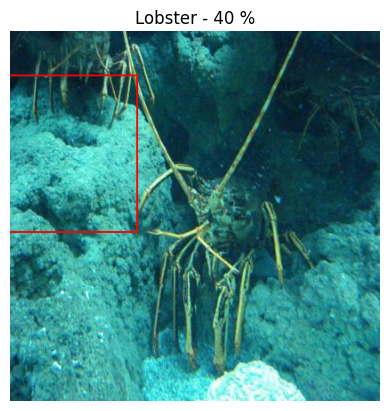

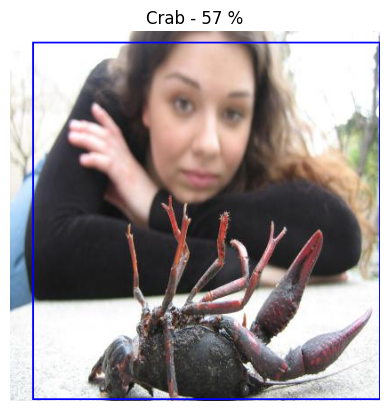

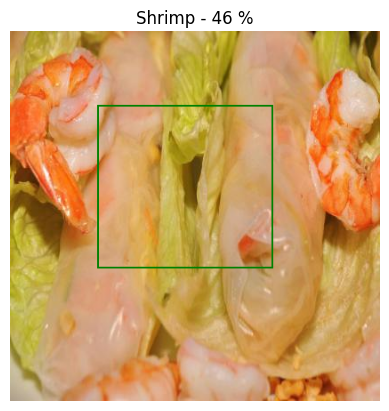

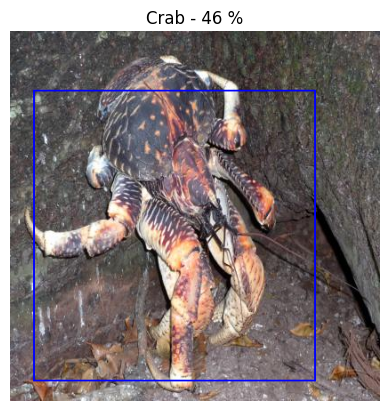

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

#Get the testing data
test_dir = pathlib.Path('/content/drive/MyDrive/nnFinalProjectFiles/shellfish_dataset/test')
img_paths = list(test_dir.glob('*.jpg'))

#standardize the size of the data
plt.figure(figsize=(20, 20))

for i, img_path in enumerate(img_paths[:15]):

    #process the image
    shellfish_img = keras.preprocessing.image.load_img(img_path, target_size=(height, width))
    img_arr = keras.preprocessing.image.img_to_array(shellfish_img)
    img_arr = tf.expand_dims(img_arr, 0)

    #make predictions
    predictions = model.predict(img_arr)

    # for classification
    score = tf.nn.softmax(predictions[0][0])
    percent = int(round(100*np.max(score), 0))
    print(classes)
    print(np.argmax(score))
    print(classes[np.argmax(score)])
    class_name = classes[np.argmax(score)]
    title = "{} - {} %".format(class_name, percent)

    # for localization
    bbox = predictions[1][0]
    bbox = [min(bbox[0], bbox[2]) * width, min(bbox[1], bbox[3]) * height, max(bbox[0], bbox[2]) * width, max(bbox[1], bbox[3]) * height]

    #draw the bounding box for the test data set
    if class_name == 'Shrimp':
      shellfish_img_arr = np.array(shellfish_img)
      cv2.rectangle(shellfish_img_arr, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 255, 255), 3)
      shellfish_img_arr_rgb = cv2.cvtColor(shellfish_img_arr, cv2.COLOR_BGR2RGB)
      plt.figure()
      plt.imshow(shellfish_img_arr_rgb)
      draw1 = Draw(shellfish_img)
      #shrimp are boxed in green
      draw1.rectangle(bbox, outline='green', width=2)

    if class_name == 'Lobster':
        shellfish_img_arr = np.array(shellfish_img)
        cv2.rectangle(shellfish_img_arr, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 255, 255), 3)
        shellfish_img_arr_rgb = cv2.cvtColor(shellfish_img_arr, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(shellfish_img_arr_rgb)
        draw1 = Draw(shellfish_img)
        #lobsters are boxed in red
        draw1.rectangle(bbox, outline='red', width=2)

    if class_name == 'Crab':
        shellfish_img_arr = np.array(shellfish_img)
        cv2.rectangle(shellfish_img_arr, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 255, 255), 3)
        shellfish_img_arr_rgb = cv2.cvtColor(shellfish_img_arr, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(shellfish_img_arr_rgb)
        draw1 = Draw(shellfish_img)
        #crabs are boxed in blue
        draw1.rectangle(bbox, outline='blue', width=2)

    plt.imshow(shellfish_img)
    plt.title(title)
    plt.axis("off")